### Анализ данных в задаче кредитного скоринга

In [ ]:
import numpy as np
import pandas as pd
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = pd.read_csv("credit_card_default_analysis.csv")
print("Всего в выборке: ", data.shape[0])
data.head()

In [ ]:
print(data.default.value_counts())
data.describe()

#### 1.a) Проверка гипотезы о равенстве медианных значений кредитного лимита с помощью интервальной оценки и бутстрепа

In [ ]:
default = data[data.default==1].LIMIT_BAL.values
med1 = np.median(default)

nodefault = data[data.default==0].LIMIT_BAL.values
med2 = np.median(nodefault)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(default, bins=30)
plt.axvline(med1, color='r', linestyle='dashed', linewidth=2)
plt.xlabel("медиана=%d" % med1)
plt.ylabel("count")
plt.title("Сумма кредита для DEFAULT==1")

plt.subplot(1,2,2)
plt.hist(nodefault, bins=30)
plt.xlabel("медиана=%d" % med2)
plt.ylabel("Кол-во")
plt.title("Сумма кредита для DEFAULT==0")
plt.axvline(med2, color='r', linestyle='dashed', linewidth=2)

plt.show()

print("Медиана для невернувших кредит: %.2f" % med1)
print("Медиана для вернувших кредит: %.2f" % med2)

Распределения отличны от нормальных, медианы не равны.

In [ ]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [ ]:
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
np.random.seed(123)

def_median_scores = np.median(get_bootstrap_samples(default, 1000), axis=1)
nodef_median_scores = np.median(get_bootstrap_samples(nodefault, 1000), axis=1)

print("95% доверительный интервал для неплательщиков:",  stat_intervals(def_median_scores))
print("95% доверительный интервал для тех, кто возвращает:",  stat_intervals(nodef_median_scores))

print("Дельта медиан", np.median(nodefault) - np.median(default))

In [ ]:
median_scores = map(lambda x: x[0] - x[1], zip(def_median_scores, nodef_median_scores))
print("Оценка разности медиан:",  stat_intervals(list(median_scores)))

Полученный интервал не содержит 0, гипотезу о равенстве медианных значений можно отвергнуть.

#### 1.б) Проверка гипотезы о равенстве распределений с помощью перестановочного критерия

Перестановчный критерий для независимых выборок:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta <\neq> 0$

Оцениваем гипотезы<br /> $H_0$: среднее значение суммы кредита одинаково для возвращающих и невозвращающих <br />
$H_1$: среднее значение суммы отличается в этих группах.

In [9]:
def permutation_test_ind(sample1, sample2, max_permutations=None):
    #sample1 и sample2 - выборки данных
    #max_permutations - максимальное количество перестановок, none без ограничений
    #return - достигаемый уровень значимости (p-value)

    t_stat = permutation_t_stat_ind(sample1, sample2)
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)    
    return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)

    
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)


def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]


def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)

    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                   for index in itertools.combinations(range(n), n1)]

    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [ ]:
%%time
pval = permutation_test_ind(nodefault, default, max_permutations=10000)
print("Достигаемый уровень значимости: %.5f" % pval)

Полученный уровень значимости очень мал, поэтому на уровне 0.05 можно отвергать нулевую гипотезу, распределения не равны.
Заявки на выдачу кредитов в размере около 80 000 - 90 000 есть смысл рассматривать более предвзято и внимательно, повышается риск невозврата.

#### 2. Проверка гипотезы о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается

In [10]:
data.SEX.value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [11]:
print("Таблица сопряженности:")
table_sex = data.pivot_table(index='default', values="LIMIT_BAL", columns='SEX', aggfunc = len, fill_value=0)
table_sex.head()

Таблица сопряженности:


SEX,1,2
default,,
0,9015,14349
1,2873,3763


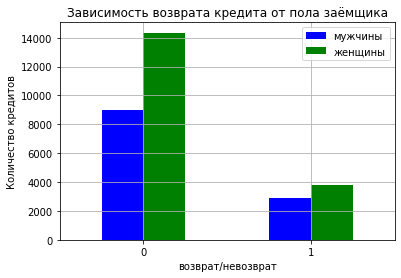

In [12]:
table_sex.plot.bar(color='bg', rot=0)
plt.xlabel("возврат/невозврат")
plt.ylabel("Количество кредитов")
plt.title("Зависимость возврата кредита от пола заёмщика")
plt.legend(["мужчины", "женщины"])
plt.grid()

plt.show()

Оценим гипотезу о совпадении состава групп по половому признаку.<br />
$H_{0} \colon p_{1} = p_{2}$

$H_{1} \colon p_{1} < \neq > p_{2}$

В данном случае <br />
$H_0$: гендерный состав групп совпадает <br />
$H_1$: гендерный состав групп различается <br />

Предположим, что выборки имеют распределения Бернулли с распределениями $Ber(p_{1})$ и $Ber(p_{2})$.

In [13]:
nodef_sex = data[data['default'] == 0]['SEX']
def_sex = data[data['default'] == 1]['SEX']

Проверка с помощью доверительного интервала:

In [14]:
def proportions_diff_confint_ind(sample1, sample2, alpha=0.05):
    z = stats.norm.ppf(1 - alpha / 2.)

    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)

    left_boundary = (p1 - p2) - z * np.sqrt(
        p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(
        p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))

    return (left_boundary, right_boundary)

In [15]:
alpha = 0.05
interval = proportions_diff_confint_ind(list(map(lambda x: 0 if x == 2 else x, nodef_sex)),
                                        list(map(lambda x: 0 if x == 2 else x, def_sex)), alpha)
print("%d доверительный интервал для разности соотношений: [%.4f], [%.4f]" % ((1 - alpha) * 100, interval[0], interval[1]))

95 доверительный интервал для разности соотношений: [-0.0605], [-0.0336]


Полученный интервал не содержит нуля, значит гендерный состав групп возвращающих и невозвращающих кредиты разный.

Проверка гипотезы тестом Фишера:

In [16]:
oddsratio, pval = stats.fisher_exact(table_sex.values, alternative='two-sided')
print("Отношение шансов: %.2f" % oddsratio)
print("P-value: %s" % pval)

Отношение шансов: 0.82
P-value: 5.2528380520530976e-12


При таком малом уровне значимости нулевая гипотеза отвергается. Половая принадлежность оказывает влияние на вероятность возврата кредита. Женщины возвращают заёмные средства чаще.

#### 3. Проверка гипотезы о том, что образование не влияет на вероятность возврата кредита

In [17]:
edu_names = ["Ph.D.", "Master", "Bachelor", "Graduate school", "Elementary education", "N/A"]
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [18]:
def_edu = data[data.default==1].EDUCATION.values
nodef_edu = data[data.default==0].EDUCATION.values

table_edu = data.pivot_table(index='default', values="LIMIT_BAL", columns='EDUCATION', aggfunc = len, fill_value=0)
table_edu.head()

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


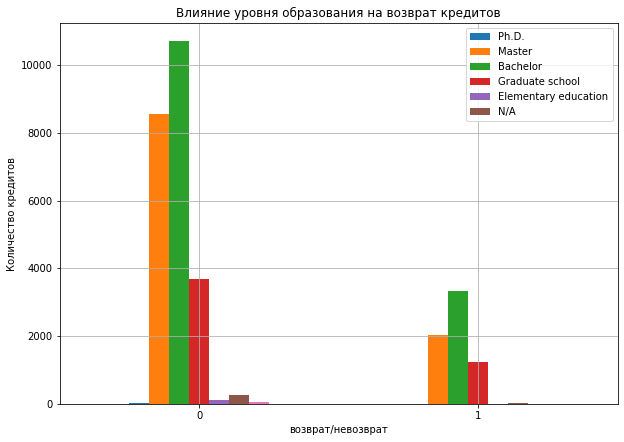

In [19]:
table_edu.plot.bar(rot=0, figsize=(10, 7))
plt.xlabel("возврат/невозврат")
plt.ylabel("Количество кредитов")
plt.title("Влияние уровня образования на возврат кредитов")
plt.legend(edu_names)
plt.grid()
plt.show()

Проверим гипотезу с помощью критерия хи-квадрат.<br />
$H_0$: уровень образования не влияет на возврат кредита <br />
$H_1$: влияет <br />

Правила для статистики хи-квадрат:
* количество объектов в таблице сопряжённости $$n \geq 40$$
* ожидаемое количество элементов в таблице $${n_{i+} n_{+j} \over n} < 5 \text{ не более, чем в 20% случаев}$$

In [20]:
print('Кол-во объектов в таблице:', np.sum(np.array(table_edu)))
print('Доля элементов меньше 5:', 1.*np.sum(np.array(table_edu) < 5) / (table_edu.shape[0] * table_edu.shape[1]))

Кол-во объектов в таблице: 30000
Доля элементов меньше 5: 0.07142857142857142


In [21]:
chi2, pval, dof, ex = stats.chi2_contingency(table_edu.values)
print("p-value: ", pval)

p-value:  1.2332626245415605e-32


Нулевая гипотеза отвергается.
Построим гистограмму соотношения наблюдаемого и ожидаемого количества человек, возвращающих кредиты.

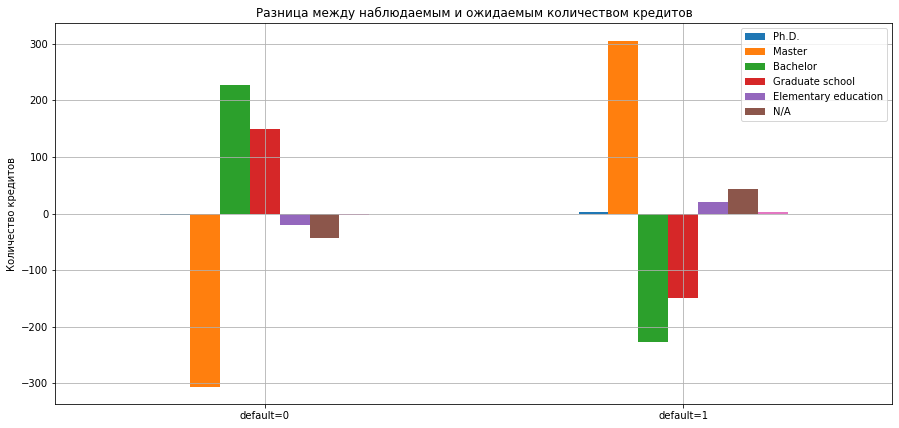

In [22]:
table_diff_edu1 = pd.DataFrame(data=ex-table_edu.values, columns=table_edu.columns)
table_diff_edu1.rename(index={0: "default=0", 1: "default=1"}, inplace=True)

table_diff_edu1.plot.bar(rot=0, figsize=(15, 7))
plt.ylabel("Количество кредитов")
plt.title("Разница между наблюдаемым и ожидаемым количеством кредитов")
plt.legend(edu_names)
plt.grid()
plt.show()

Построим гистограмму разности между возвращающими и невозвращающими по каждому из уровней образования.

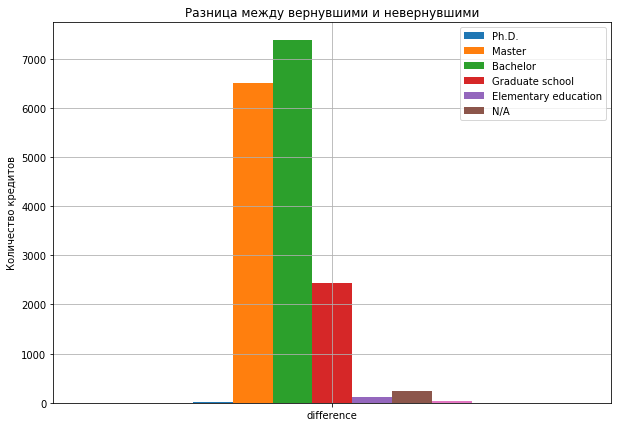

In [23]:
table_diff_edu2 = pd.DataFrame(data=(table_edu.loc[0] - table_edu.loc[1]).values.reshape(1,7),
                               columns=table_edu.columns, index = ["difference"])

table_diff_edu2.plot.bar(rot=0, figsize=(10, 7))
plt.ylabel("Количество кредитов")
plt.title("Разница между вернувшими и невернувшими")
plt.legend(edu_names)
plt.grid()
plt.show()

Отнормируем значения, для этого разделим каждое значение разности на количество людей в этой подгруппе. Чем больше полученное значение, тем больше доля людей с этим уровнем образования вернули кредит.

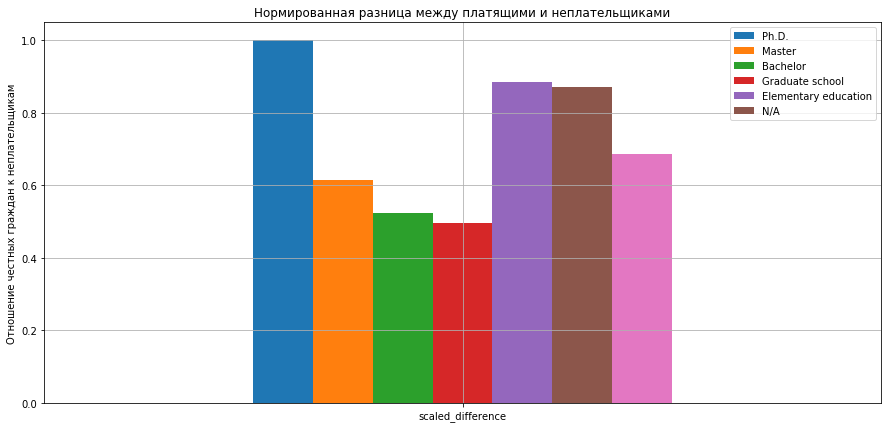

In [24]:
diff_edu2_scaled = (table_edu.loc[0] - table_edu.loc[1]) / ((table_edu.loc[0] + table_edu.loc[1]))
table_diff_edu2_scaled = pd.DataFrame(data=diff_edu2_scaled.values.reshape(1,7),
                                      columns=table_edu.columns, index = ["scaled_difference"])

table_diff_edu2_scaled.plot.bar(rot=0, figsize=(15, 7))
plt.ylabel("Отношение честных граждан к неплательщикам")
plt.title("Нормированная разница между платящими и неплательщиками")
plt.legend(edu_names)
plt.grid()
plt.show()

Вывод: доктора и магистры чаще возвращают кредиты, люди со средним образованием и бакалавры  - не самые надёжные заёмщики.

#### 4. Проверка связи семейного положения с индикатором дефолта

In [ ]:
mar_names = ["refused", "married", "single", "N/A"]
data.MARRIAGE.value_counts()

In [ ]:
table_mar = data.pivot_table(index='default', 
     values="LIMIT_BAL", columns='MARRIAGE', aggfunc = len, fill_value=0)
table_mar.head()

In [ ]:
table_mar.plot.bar(rot=0, figsize=(10, 7))
plt.xlabel("возврат/невозврат")
plt.ylabel("Количество кредитов")
plt.title("Влияние семейного положения на возврат кредитов")
plt.legend(mar_names)
plt.grid()
plt.show()

Применимость критерия хи-квадрат:

In [ ]:
print('Кол-во измерений в совокупной выборке:', np.sum(np.array(table_mar)))
print('Доля элементов меньше 5:', np.sum(np.array(table_mar) < 5) / (table_mar.values.shape[0] * table_mar.values.shape[1])) 

In [ ]:
chi2, p, dof, exp = stats.chi2_contingency(table_mar)

n = table_mar.sum(axis = 0).sum()
cr_v = (chi2 / n) ** 0.5

print('Коэффициент Крамера V = %.4f' % cr_v)
print('p-value = ', p)

Вывод: корреляция слабая, на уровне значимости 0.05 можно утверждать, что семейное положение заёмщика не влияет на вероятность возврата кредита.

#### 5.а) Проверка гипотезы о равенстве медианных значений возрастов людей

In [ ]:
nodef_age = data[data['default'] == 0].AGE.values
def_age = data[data['default'] == 1].AGE.values

nodef_age_median = np.median(nodef_age)
def_age_median = np.median(def_age)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(def_age, bins=30)
plt.axvline(def_age_median, color='r', linestyle='dashed', linewidth=2)
plt.xlabel("возраст (медиана=%d)" % def_age_median)
plt.ylabel("Количество кредитов")
plt.title("Возраст невозвращающих")

plt.subplot(1,2,2)
plt.hist(nodef_age, bins=30)
plt.xlabel("возраст (медиана=%d)" % nodef_age_median)
plt.ylabel("Количество кредитов")
plt.title("Возраст возвращающих")
plt.axvline(nodef_age_median, color='r', linestyle='dashed', linewidth=2)

plt.show()

print("Медиана для DEF=1: %.2f" % def_age_median)
print("Медиана для DEF=0: %.2f" % nodef_age_median)

Распределения не являются нормальными.

In [ ]:
np.random.seed(123)

def_median_scores = np.median(get_bootstrap_samples(def_age, 1000), axis=1)
nodef_median_scores = np.median(get_bootstrap_samples(nodef_age, 1000), axis=1)

print("95% доверительный интервал для невозвращающих кредиты:",  stat_intervals(def_median_scores))
print("95% доверительный интервал для возвращающих кредиты:",  stat_intervals(nodef_median_scores))

In [ ]:
Интервалы пересекаются, а значит нужен интервал для разности.

In [ ]:
age_median_delta = np.array(nodef_median_scores) - np.array(def_median_scores)
stat_intervals(age_median_delta, 0.05)

Полученный интервал содержит нуль. Видимо, медианы не сильно отличаются.

#### 5.б) Проверка гипотезы о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

Применим Критерий Манна-Уитни для проверки равенства средних: <br />
$H_0$: средние равны <br />
$H_1$: средние не равны <br />

In [ ]:
stats.mannwhitneyu(def_age, nodef_age)

Уровень значимости выше 0.05, то есть нулевую гипотезу отвергать нельзя.
Вывод: возраст заёмщика не имеет сильного влияния на вероятность возврата кредита.